In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from numpy.core.numeric import full
import pickle
import time
import random 
import pprint
import warnings
from collections import Counter
from scipy.spatial import distance
from operator import itemgetter


from copy import deepcopy

from sklearn.metrics import accuracy_score, confusion_matrix, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster

import skimage
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from skimage.color import gray2rgb, rgb2gray, label2rgb

from scipy.ndimage import convolve
from scipy.stats import zscore


# For keras dependencise
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Activation, Lambda, Reshape, Flatten
from keras.layers import BatchNormalization
from keras import losses
from keras import backend as K
from keras.losses import mse
from keras.optimizers import Adam

import sage


# For LRP Visuals
# from deepexplain.tensorflow import DeepExplain
from keras.models import Model

# LIME
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries, slic
from scipy import ndimage

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster

from PIL import Image


Using TensorFlow backend.


In [2]:
model = load_model("NN4.h5")

# Load data
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

# Load the feature activations
X_train_act = np.load("X_train_act.npy")
X_test_act = np.load("X_test_act.npy")

# Load DeepLIFT contributions
X_train_cont = np.load("new_X_train_deeplift.npy")
X_test_cont = np.load("new_X_test_deeplift.npy")

# X_test_cont shape
X_test_cont.shape

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



2023-09-14 16:31:36.760836: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-09-14 16:31:36.775618: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe707053340 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-09-14 16:31:36.775645: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


(10000, 128)

In [3]:
# Normalise the data 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


In [4]:
if False:
    from sklearn.utils import resample
    print("Work with few data")
    X_train, y_train = resample(X_train, y_train, replace=False, n_samples=1000, random_state=0, stratify=y_train)   

In [5]:
from lime_utils import get_top_features

top_five_features_file = "top_1000_features_lime_fixed.pkl"


if not os.path.exists(top_five_features_file):
    # print("Compute", top_five_features_file)
    class_top_features = get_top_features(X_train, y_train, model, num_features=1000, max_per_image=10)
    # Save the dictionary to a file
    with open(top_five_features_file, "wb") as f:
        pickle.dump(class_top_features, f)

else:
    # print("Load", top_five_features_file)
    with open(top_five_features_file, 'rb') as f:
        class_top_features = pickle.load(f)

In [6]:
from aggregate import aggregate_superpixels

aggregated_result_file = "aggregated_result.pkl"

if not os.path.exists(aggregated_result_file):
    aggregated_superpixels = aggregate_superpixels(class_top_features)

    with open(aggregated_result_file, "wb") as f:
        pickle.dump(aggregated_superpixels, f)
else:
    print("Load", aggregated_result_file)
    with open(aggregated_result_file, "rb") as f:
        aggregated_superpixels = pickle.load(f)


Load aggregated_result.pkl


In [7]:
import numpy as np
import random

# Initialise a dictionary to store the aggregated SAGE importances
sage_importances = {}
patience_counter = {}

# Parameters for early stopping
EARLY_STOPPING_THRESHOLD = 1e-2
EARLY_STOPPING_PATIENCE = 5

# Counter for debug prints
debug_counter = 0

# Sample ratio for superpixels and instances
SAMPLE_RATIO = 0.7

# Batch size for processing instances
BATCH_SIZE = 32

def turn_off_superpixel(image, mask):
    modified_image = np.copy(image)
    modified_image[0, 0, mask] = np.mean(image)
    return modified_image

def importance_function(baseline_pred, new_pred, true_class):
    return abs(baseline_pred[true_class] - new_pred[true_class])

def calculate_instance_importance(baseline_pred, modified_pred, true_label):
    return importance_function(baseline_pred, modified_pred, true_label)

def dataset_for_class(class_id):
    instances = X_test[y_test == class_id]
    labels = y_test[y_test == class_id]
    return list(zip(instances, labels))

# Main loop for SAGE analysis
for class_id, aggregated_features in aggregated_superpixels.items():
    sampled_features = random.sample(aggregated_features, int(len(aggregated_features) * SAMPLE_RATIO))

    for index, aggregated_superpixel in enumerate(sampled_features):
        mask, image, score, imgid = aggregated_superpixel

        print(f"Debug: Working on superpixel index {index} with mask shape {mask.shape}")

        patience_counter[index] = 0
        prev_sage_importance = 0

        # Generate the dataset instances belonging to the class
        dataset_list = dataset_for_class(class_id)
        sampled_data = random.sample(dataset_list, int(len(dataset_list) * SAMPLE_RATIO))

        batch_sage_importance = 0
        n_batches = int(np.ceil(len(sampled_data) / BATCH_SIZE))

        for i in range(n_batches):
            batch_data = sampled_data[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
            batch_instance_importance = []

            for instance, true_label in batch_data:
                if len(instance.shape) == 2:
                    instance = np.expand_dims(instance, axis=-1)
                if len(instance.shape) == 3:
                    reshaped_instance = np.expand_dims(instance, axis=0)

                baseline_pred = model.predict(reshaped_instance)[0]
                modified_instance = turn_off_superpixel(reshaped_instance, mask)
                modified_pred = model.predict(modified_instance)[0]

                instance_importance = calculate_instance_importance(baseline_pred, modified_pred, true_label)
                batch_instance_importance.append(instance_importance)

            batch_sage_importance += np.mean(batch_instance_importance)
            print(f"Batch SAGE Importance: {batch_sage_importance}")

            if np.abs(prev_sage_importance - batch_sage_importance) < EARLY_STOPPING_THRESHOLD:
                patience_counter[index] += 1
                print(f"Patience Counter for superpixel {index}: {patience_counter[index]}")

                if patience_counter[index] >= EARLY_STOPPING_PATIENCE:
                    print(f"Early stopping for superpixel {index}")
                    break
            else:
                patience_counter[index] = 0

            prev_sage_importance = batch_sage_importance
            print(f"Previous SAGE Importance: {prev_sage_importance}")

        sage_importance = batch_sage_importance / n_batches

        sage_importance_data = {
            'importance': sage_importance,
            'mask': mask
        }

        if class_id not in sage_importances:
            sage_importances[class_id] = {}

        sage_importances[class_id][index] = sage_importance_data

# Display the top 3 most important superpixels for each class
for class_id, importances in sage_importances.items():
    top_3_features = sorted(importances.items(), key=lambda x: x[1]['importance'], reverse=True)[:3]
    print(f"Top 3 features for class {class_id}: {top_3_features}")



# Save the SAGE importances to a pickle file
with open("sage_importances.pkl", "wb") as f:
    pickle.dump(sage_importances, f)

#open the sage pickle file
with open("sage_importances.pkl", "rb") as f:
    sage_importances = pickle.load(f)


In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate overlap between two masks
def calculate_overlap(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    overlap = np.sum(intersection)
    return overlap

# Initialise a dictionary to store the clustered top features for each class
clustered_top_features = {}

# Loop over each class to perform K-means clustering
for class_id, importances in sage_importances.items():
    
    # Extract mask vectors and flatten them
    mask_vectors = np.array([mask_data['mask'].flatten() for _, mask_data in importances.items()])
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=7, random_state=0).fit(mask_vectors)
    
    # Labels for each point
    labels = kmeans.labels_
    
    # Initialise a dictionary to store the most important feature from each cluster
    cluster_representatives = {}
    
    for i, label in enumerate(labels):
        if label not in cluster_representatives:
            cluster_representatives[label] = {'index': i, 'importance': importances[i]['importance']}
        else:
            if importances[i]['importance'] > cluster_representatives[label]['importance']:
                cluster_representatives[label] = {'index': i, 'importance': importances[i]['importance']}
    
    # Extract the most important feature from each cluster
    top_features = [importances[rep['index']] for rep in cluster_representatives.values()]
    
    # Sort these features by importance
    top_features = sorted(top_features, key=lambda x: x['importance'], reverse=True)
    
    # Create a list of non-overlapping top features
    non_overlapping_top_features = []

    fallback_features = []
    
    # Iterate to select non-overlapping top features
    for feature in top_features:
        overlap_with_existing = [calculate_overlap(feature['mask'], existing['mask']) for existing in non_overlapping_top_features]
        
        if all(overlap < 8 for overlap in overlap_with_existing): 
            non_overlapping_top_features.append(feature)
        else:
            fallback_features.append(feature)
        
        if len(non_overlapping_top_features) >= 3:
            break
    
    # Fallback mechanism
    if len(non_overlapping_top_features) < 3:
        remaining_slots = 3 - len(non_overlapping_top_features)
        non_overlapping_top_features.extend(fallback_features[:remaining_slots])
        
    # Save these non-overlapping top features
    clustered_top_features[class_id] = non_overlapping_top_features[:3]

# Let's print out the clustered top 3 features for each class to verify
for class_id, features in clustered_top_features.items():
    print(f"Clustered top 3 features for class {class_id}: {features}")

# Save the clustered top features to a npy file
np.save("clustered_top_features.npy", clustered_top_features)


Clustered top 3 features for class 0: [{'importance': 3.8465019315481186e-05, 'mask': array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False]

In [9]:
def weighted_average(features, weights):
    weighted_features = np.zeros_like(features[0]).astype(np.float64) 
    total_weight = 0
    
    for feature, weight in zip(features, weights):
        weighted_features += feature.astype(np.float64) * weight  
        total_weight += weight
        
    return weighted_features / total_weight


# Example usage
meta_features = {}

# Loop through each class's top 3 features
for class_id, top_features in clustered_top_features.items():
    # Assume each 'feature' is represented by a NumPy array
    feature_arrays = [feature['mask'] for feature in top_features]
    
    # Example weights, replace with your actual weights
    weights = [feature['importance'] for feature in top_features]  # feature['importance'] should contain the importance of each feature
    
    # Calculate the weighted average feature
    meta_feature = weighted_average(feature_arrays, weights)
    
    # Save to the meta_features dictionary
    meta_features[class_id] = meta_feature

np.save('meta_features.npy', meta_features)


In [11]:
averages = {}
for label in np.unique(y_train):
    class_indices = np.where(y_train == label)[0]
    average_image = np.mean(X_train[class_indices], axis=0)
    averages[label] = average_image

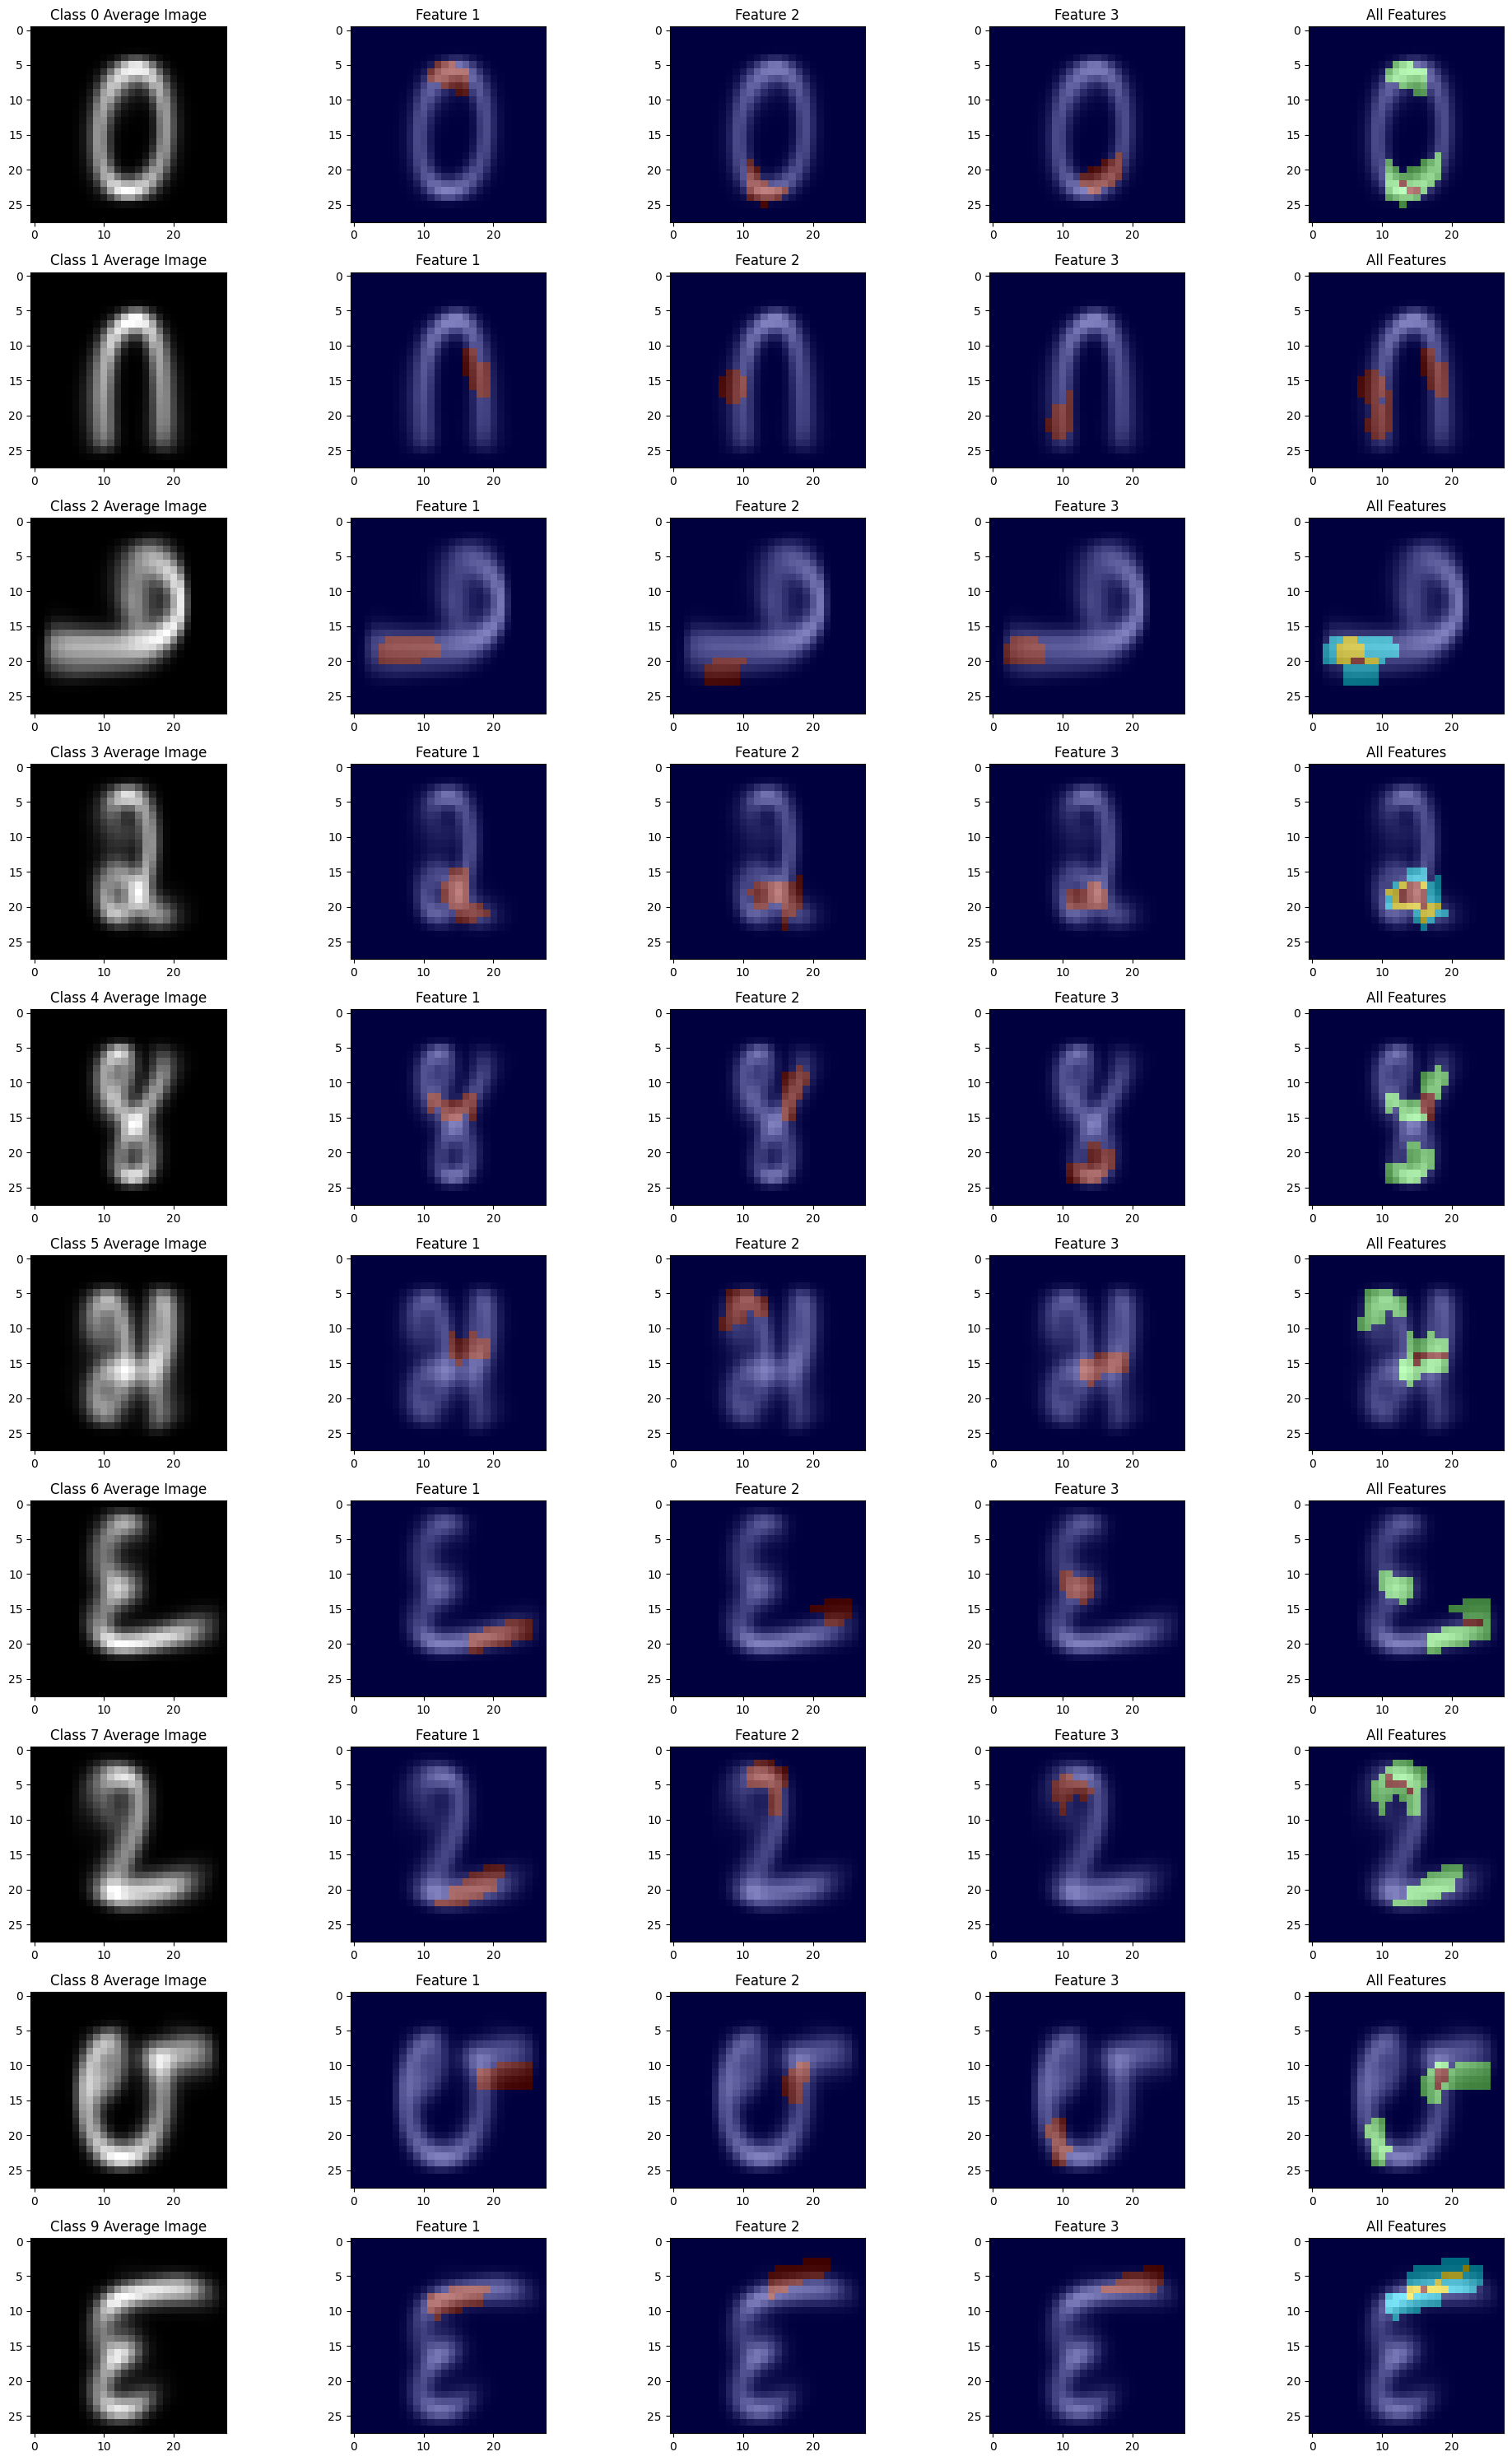

In [12]:
fig, axs = plt.subplots(len(averages), 5, figsize=(20, len(averages) * 3))  # Create subplots

# Iterate over each class and its average image
for idx, (label, average_image) in enumerate(averages.items()):
    axs[idx, 0].imshow(np.squeeze(average_image), cmap='gray')
    axs[idx, 0].set_title(f"Class {label} Average Image")
  
    # Fetch top 3 features for this class from clustered_top_features
    top_3_features = clustered_top_features.get(label, [])
  
    # Overlay individual and combined masks
    for i, feature_data in enumerate(top_3_features[:3]):
        # Individual masks
        axs[idx, i + 1].imshow(np.squeeze(average_image), cmap='gray')
        axs[idx, i + 1].imshow(feature_data['mask'], cmap='jet', alpha=0.5)
        axs[idx, i + 1].set_title(f"Feature {i+1}")
  
    # Combined mask
    combined_mask = np.sum([feature_data['mask'] for feature_data in top_3_features[:3]], axis=0)
    axs[idx, 4].imshow(np.squeeze(average_image), cmap='gray')
    axs[idx, 4].imshow(combined_mask, cmap='jet', alpha=0.5)
    axs[idx, 4].set_title(f"All Features")

plt.tight_layout()
plt.show()
